## Coffee Global Analysis
This notebook explores the global coffee industry with a focus on production, trade, and consumption trends. By analyzing data on green coffee production, harvested areas, imports, exports, and consumption patterns, this project aims to uncover interesting insights and phenomena that shape the coffee market worldwide to better understand the dynamics of this essential commodity.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format 

The main **data source** used for this analysis consists of three separate datasets provided by FAOSTAT (Food and Agriculture Organisation) https://www.fao.org/faostat/en/
> Green Coffee Production Data - Time Range: 1961 - 2023

    -> Annual production quantities of green coffee beans by country

> Green Coffee Trade Data - Time Range: 1961 - 2023

    -> Import and export volumes and values of green coffee

> Balance Data - Time Range: 2010 - 2022

    -> Indicators on stock variations, supply quantity etc.

### First Data Unterstandings - (PRODUCTION QUANTITY & AREA HARVESTED)
The global production of coffee increased over the last centuries. Which countries dominate the coffee production market?

In [2]:
df_prod = pd.read_csv("./raw_data/production-quantity_raw.csv")
df_prod.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1961,1961,ha,350000.00,A,Official figure,NaN
1,QCL,Crops and livestock products,24,Angola,5510,Production,1610,"Coffee, green",1961,1961,t,168600.00,A,Official figure,NaN
2,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1962,1962,ha,500000.00,A,Official figure,NaN
3,QCL,Crops and livestock products,24,Angola,5510,Production,1610,"Coffee, green",1962,1962,t,185000.00,A,Official figure,NaN
4,QCL,Crops and livestock products,24,Angola,5312,Area harvested,1610,"Coffee, green",1963,1963,ha,500000.00,E,Estimated value,NaN


In [3]:
df_prod.shape

(10556, 15)

In [4]:
df_prod.dtypes

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                 object
dtype: object

In [5]:
df_prod.describe()

,Area Code (M49),Element Code,Item Code (CPC),Year Code,Year,Value
count,10556.00,10556.00,10556.00,10556.00,10556.00,10188.00
mean,426.64,5411.32,1610.00,1991.81,1991.81,103928.82
std,245.77,99.00,0.00,18.14,18.14,298442.80
min,24.00,5312.00,1610.00,1961.00,1961.00,0.00
25%,192.00,5312.00,1610.00,1976.00,1976.00,540.00
50%,404.00,5510.00,1610.00,1992.00,1992.00,10000.00
75%,630.00,5510.00,1610.00,2007.00,2007.00,78043.75
max,894.00,5510.00,1610.00,2023.00,2023.00,4462657.00


In [6]:
#Columns to keep: Area Code (M49), Area, Element (make own columns for each element), Year, Unit, Value
def drop_cols(df, cols_arr):
    return df.drop(columns=cols_arr)

df_prod = drop_cols(df_prod, ['Domain Code', 'Domain', 'Element Code', 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note'])

In [7]:
df_prod.head()

,Area Code (M49),Area,Element,Item,Year,Unit,Value
0,24,Angola,Area harvested,"Coffee, green",1961,ha,350000.00
1,24,Angola,Production,"Coffee, green",1961,t,168600.00
2,24,Angola,Area harvested,"Coffee, green",1962,ha,500000.00
3,24,Angola,Production,"Coffee, green",1962,t,185000.00
4,24,Angola,Area harvested,"Coffee, green",1963,ha,500000.00


In [8]:
#rearrange dataframe to have elements as own columns
def pivot_handler(df, index, cols, val):
    df = df.pivot_table(
        index=index,
        columns=cols,
        values=val
    ).reset_index() 
    df.columns.name = None 
    return df

df_prod = pivot_handler(df_prod, ['Area Code (M49)', 'Area', 'Year'], 'Element', 'Value')

In [9]:
#renaming columns
def rename_cols(df, cols):
    return df.rename(columns=cols)

df_prod = rename_cols(df_prod, {"Area Code (M49)":"Area_code", "Area harvested":"Area_harvested_hectar", "Production":"Production_quantity_tonnes"})

In [10]:
df_prod.head()

,Area_code,Area,Year,Area_harvested_hectar,Production_quantity_tonnes
0,24,Angola,1961,350000.00,168600.00
1,24,Angola,1962,500000.00,185000.00
2,24,Angola,1963,500000.00,168300.00
3,24,Angola,1964,500000.00,198200.00
4,24,Angola,1965,500000.00,205000.00


In [11]:
#save version 2 of production df
df_prod.to_csv('production-quantity_pivoted.csv', index=False)

In [12]:
#get top countries with high green coffee production quantity on average
top_producer = df_prod.groupby("Area")[["Production_quantity_tonnes"]].mean().sort_values(by=["Production_quantity_tonnes"], ascending=False).head(8)

In [13]:
top_producer.head(15)

,Production_quantity_tonnes
Area,
Brazil,1912080.68
Colombia,655110.90
Viet Nam,535367.43
Indonesia,435206.09
Ethiopia,320333.47
Mexico,250006.22
Guatemala,199471.56
Côte d'Ivoire,198883.18


In [14]:
#NULL Values - only Spain: Area_harvested_hectar affected
#leave as is for transparency
df_prod.isna().sum()

Area_code                      0
Area                           0
Year                           0
Area_harvested_hectar         34
Production_quantity_tonnes     0
dtype: int64

In [15]:
#formatter for million numbers
def formatter(x, pos):
    """Formatiert eine Zahl in Millionen mit zwei Nachkommastellen."""
    return f'{x / 1_000_000:.2f}'

### First Plots - (PRODUCTION QUANTITY & AREA HARVESTED)

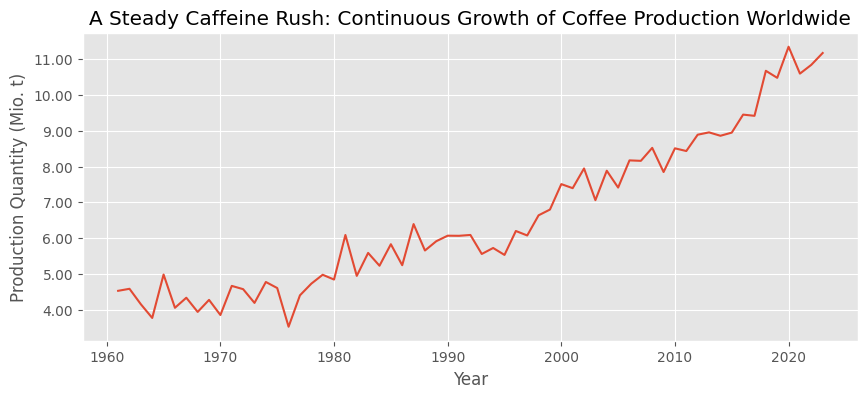

In [16]:
# World Coffee Production
df_prod_world = df_prod.groupby("Year")[["Production_quantity_tonnes"]].sum()
ax = df_prod_world.plot(kind="line", figsize=(10,4), title="A Steady Caffeine Rush: Continuous Growth of Coffee Production Worldwide", 
                        legend=False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel("Production Quantity (Mio. t)")
plt.show()

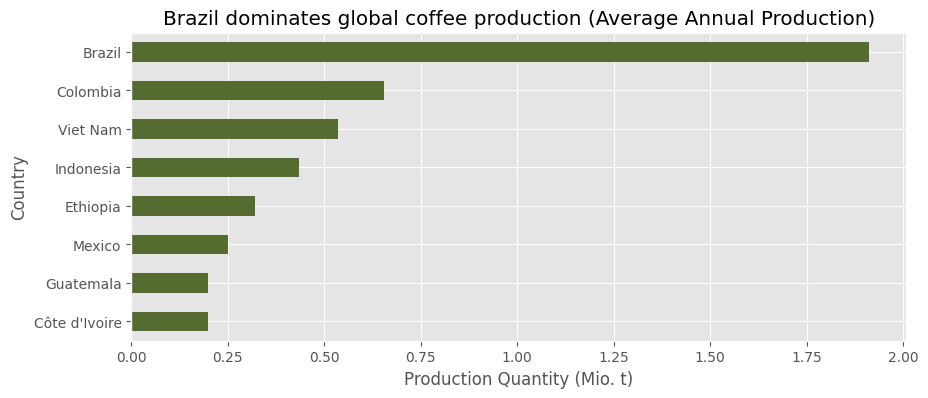

In [17]:
#plot top producing countries
ax = top_producer.plot(kind="barh", title="Brazil dominates global coffee production (Average Annual Production)", 
                       legend=False, figsize=(10,4), color="#556B2F")
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel("Country")
ax.set_xlabel("Production Quantity (Mio. t)")
plt.show()

In [18]:
top_harvester = df_prod.groupby("Area")[["Area_harvested_hectar"]].mean().sort_values(by=["Area_harvested_hectar"], ascending=False).head(8)

In [19]:
top_harvester

,Area_harvested_hectar
Area,
Brazil,2403731.95
Colombia,857889.21
Indonesia,796926.02
Côte d'Ivoire,771125.95
Mexico,576365.46
Ethiopia PDR,473115.41
Ethiopia,465562.13
Uganda,307538.19


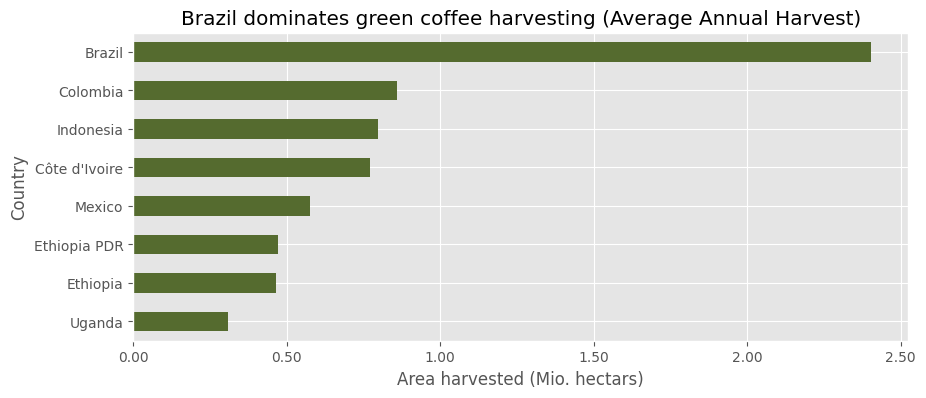

In [20]:
#plot top harvester countries
ax = top_harvester.plot(kind="barh", title="Brazil dominates green coffee harvesting (Average Annual Harvest)", 
                       legend=False, figsize=(10,4), color="#556B2F")
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.set_ylabel("Country")
ax.set_xlabel("Area harvested (Mio. hectars)")
plt.show()

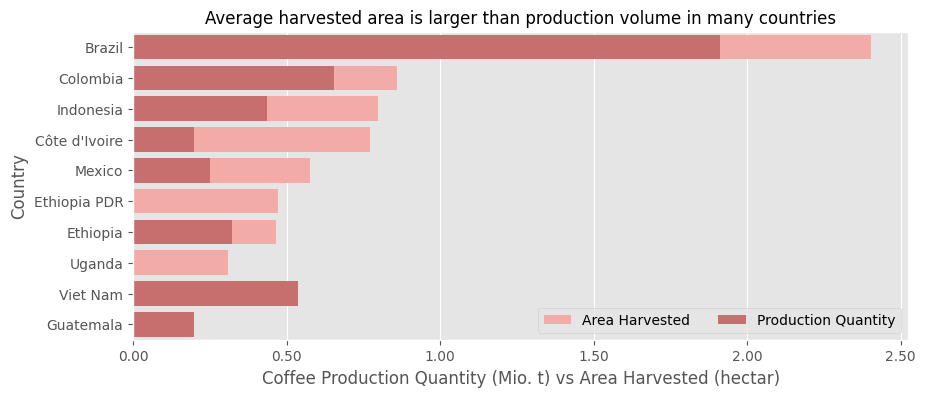

In [21]:
fig, ax = plt.subplots(figsize=(10, 4)) 

# Plot the avg area harvested
sns.set_color_codes("pastel")
ax = sns.barplot(x="Area_harvested_hectar", y="Area", data=top_harvester,
            label="Area Harvested", color="r")

# Plot the avg production quantity
sns.set_color_codes("muted")
ax = sns.barplot(x="Production_quantity_tonnes", y="Area", data=top_producer,
            label="Production Quantity", color="r")

ax.set_title("Average harvested area is larger than production volume in many countries", fontsize=12)
ax.set_xlabel("Coffee Production Quantity (Mio. t) vs Area Harvested (hectar)")
ax.set_ylabel("Country")

ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.show()

### Time Series of Top 4 Producers

In [22]:
top4_prod = df_prod.groupby(["Area", "Year"])[["Production_quantity_tonnes"]].mean().sort_values(by=["Production_quantity_tonnes"])

In [23]:
top4_prod = top4_prod.loc[["Brazil", "Colombia", "Viet Nam", "Indonesia"]].reset_index()

In [24]:
top4_prod

,Area,Year,Production_quantity_tonnes
0,Brazil,1976,375985.00
1,Brazil,1970,754800.00
2,Brazil,1973,872897.00
3,Brazil,1995,930135.00
4,Brazil,1982,957931.00
...,...,...,...
247,Indonesia,2018,756051.00
248,Indonesia,2023,760192.20
249,Indonesia,2020,762380.00
250,Indonesia,2022,774960.53


In [25]:
top4_prod = pivot_handler(top4_prod, ['Year'], 'Area', 'Production_quantity_tonnes')

In [26]:
top4_prod

,Year,Brazil,Colombia,Indonesia,Viet Nam
0,1961,2228704.00,450000.00,103100.00,4100.00
1,1962,2190303.00,482100.00,106700.00,4020.00
2,1963,1650527.00,450000.00,139600.00,4500.00
3,1964,1042013.00,468000.00,118200.00,5500.00
4,1965,2294047.00,492000.00,134500.00,7500.00
...,...,...,...,...,...
58,2019,3011745.00,885120.00,752512.00,1686765.17
59,2020,3705719.00,833400.00,762380.00,1763476.04
60,2021,2985581.00,560340.00,786191.00,1845032.98
61,2022,3179176.00,665015.95,774960.53,1953990.16


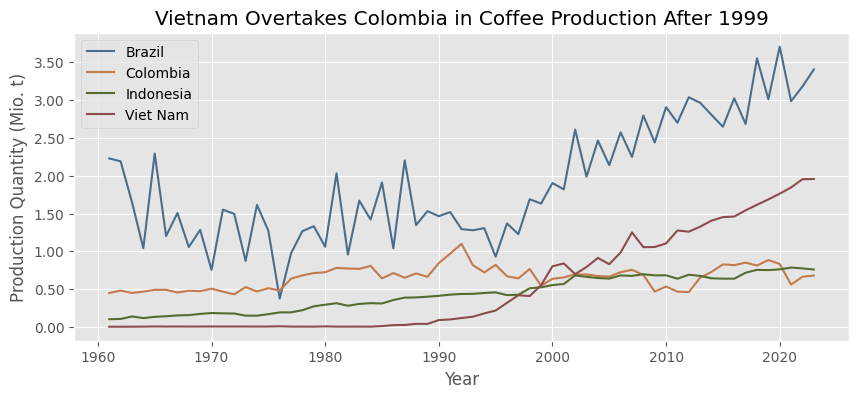

In [27]:
ax = top4_prod.plot(kind="line", x="Year", title="Vietnam Overtakes Colombia in Coffee Production After 1999", 
                    figsize=(10,4), color={"Brazil": "#4A6D8C", "Colombia": "#C37B4D", "Indonesia": "#556B2F", "Viet Nam": "#8B4C4C"})
ax.set_ylabel("Production Quantity (Mio. t)")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.show()

### Yield - Production Quantity / Area Harvested

In [28]:
df_agg = df_prod.groupby(['Year', 'Area']).agg({
    'Production_quantity_tonnes': 'sum',
    'Area_harvested_hectar': 'sum'
}).reset_index()

In [29]:
df_agg['Yield'] = df_agg['Production_quantity_tonnes'] / df_agg['Area_harvested_hectar']
yield_pivot = pivot_handler(
    df_agg,
    ['Year'],
    'Area',
    'Yield'
)

yield_pivot = yield_pivot[["Year", "Brazil", "Colombia", "Indonesia", "Viet Nam"]]

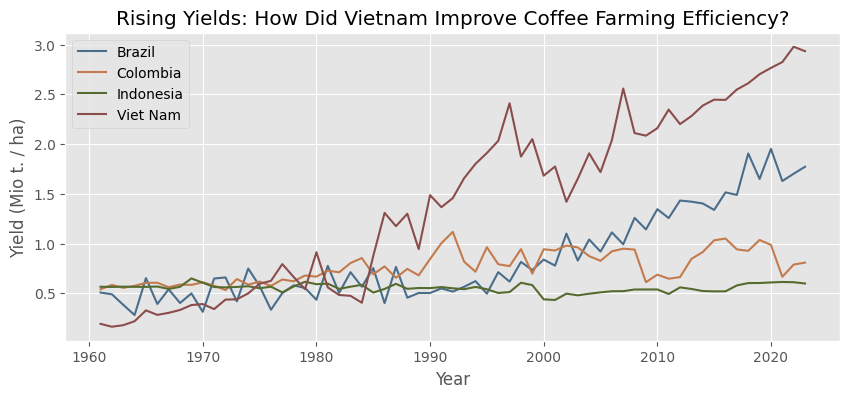

In [30]:
ax = yield_pivot.plot(kind="line", x="Year", title="Rising Yields: How Did Vietnam Improve Coffee Farming Efficiency?", 
                    figsize=(10,4), color={"Brazil": "#4A6D8C", "Colombia": "#C37B4D", "Indonesia": "#556B2F", "Viet Nam": "#8B4C4C"})
ax.set_ylabel("Yield (Mio t. / ha)")
plt.show()

### First Data Understandings - (TRADE)

In [31]:
df_trade = pd.read_csv("./raw_data/trade_raw.csv")

In [32]:
df_trade.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,TCL,Crops and livestock products,4,Afghanistan,5610,Import quantity,1610,"Coffee, green",1961,1961,t,0.00,A,Official figure,NaN
1,TCL,Crops and livestock products,4,Afghanistan,5622,Import value,1610,"Coffee, green",1961,1961,1000 USD,0.00,A,Official figure,NaN
2,TCL,Crops and livestock products,4,Afghanistan,5610,Import quantity,1610,"Coffee, green",1962,1962,t,0.00,A,Official figure,NaN
3,TCL,Crops and livestock products,4,Afghanistan,5622,Import value,1610,"Coffee, green",1962,1962,1000 USD,0.00,A,Official figure,NaN
4,TCL,Crops and livestock products,4,Afghanistan,5610,Import quantity,1610,"Coffee, green",1963,1963,t,0.00,A,Official figure,NaN


In [33]:
df_trade.shape

(39534, 15)

In [34]:
df_trade.dtypes

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
Note                 object
dtype: object

In [35]:
#Columns to keep: Area Code (M49), Area, Element (make own columns for each element), Year, Unit, Value
df_trade = drop_cols(df_trade, ['Domain Code', 'Domain', 'Element Code', 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note'])

In [36]:
df_trade

,Area Code (M49),Area,Element,Item,Year,Unit,Value
0,4,Afghanistan,Import quantity,"Coffee, green",1961,t,0.00
1,4,Afghanistan,Import value,"Coffee, green",1961,1000 USD,0.00
2,4,Afghanistan,Import quantity,"Coffee, green",1962,t,0.00
3,4,Afghanistan,Import value,"Coffee, green",1962,1000 USD,0.00
4,4,Afghanistan,Import quantity,"Coffee, green",1963,t,0.00
...,...,...,...,...,...,...,...
39529,716,Zimbabwe,Export value,"Coffee, green",2022,1000 USD,365.00
39530,716,Zimbabwe,Import quantity,"Coffee, green",2023,t,26.16
39531,716,Zimbabwe,Import value,"Coffee, green",2023,1000 USD,23.00
39532,716,Zimbabwe,Export quantity,"Coffee, green",2023,t,43.70


In [37]:
#rearrange dataframe to have elements as own columns
df_trade = pivot_handler(df_trade, ['Area Code (M49)', 'Area', 'Year'], 'Element', 'Value')

In [38]:
df_trade = rename_cols(df_trade, {"Area Code (M49)":"Area_code", "Export quantity":"export_quantity_tonnes", "Export value":"export_value_1000_usd", "Import quantity":"import_quantity_tonnes", "Import value":"import_value_1000_usd"})

In [39]:
df_trade

,Area_code,Area,Year,export_quantity_tonnes,export_value_1000_usd,import_quantity_tonnes,import_value_1000_usd
0,4,Afghanistan,1961,NaN,NaN,0.00,0.00
1,4,Afghanistan,1962,NaN,NaN,0.00,0.00
2,4,Afghanistan,1963,NaN,NaN,0.00,0.00
3,4,Afghanistan,1964,NaN,NaN,0.00,0.00
4,4,Afghanistan,1965,NaN,NaN,0.00,0.00
...,...,...,...,...,...,...,...
11121,894,Zambia,2019,1213.58,3236.00,21.96,123.00
11122,894,Zambia,2020,2100.69,6701.00,43.80,183.00
11123,894,Zambia,2021,3766.61,13978.00,31.90,163.00
11124,894,Zambia,2022,4933.48,23717.00,23.50,183.00


In [40]:
#NULL values
df_trade.isna().sum()

Area_code                    0
Area                         0
Year                         0
export_quantity_tonnes    2051
export_value_1000_usd     2012
import_quantity_tonnes     488
import_value_1000_usd      419
dtype: int64

In [41]:
df_trade.loc[df_trade["export_quantity_tonnes"].isnull()]

,Area_code,Area,Year,export_quantity_tonnes,export_value_1000_usd,import_quantity_tonnes,import_value_1000_usd
0,4,Afghanistan,1961,NaN,NaN,0.00,0.00
1,4,Afghanistan,1962,NaN,NaN,0.00,0.00
2,4,Afghanistan,1963,NaN,NaN,0.00,0.00
3,4,Afghanistan,1964,NaN,NaN,0.00,0.00
4,4,Afghanistan,1965,NaN,NaN,0.00,0.00
...,...,...,...,...,...,...,...
10954,882,Samoa,2023,NaN,NaN,6.23,54.00
11049,891,Serbia and Montenegro,1992,NaN,0.00,26257.00,39466.00
11050,891,Serbia and Montenegro,1993,NaN,0.00,0.00,0.00
11051,891,Serbia and Montenegro,1994,NaN,0.00,1400.00,4000.00


In [42]:
df_trade.isna().mean() * 100

Area_code                 0.00
Area                      0.00
Year                      0.00
export_quantity_tonnes   18.43
export_value_1000_usd    18.08
import_quantity_tonnes    4.39
import_value_1000_usd     3.77
dtype: float64

In [43]:
#for simplicity let countries with NaN values in the df but replace NaN with zero to implicate "No Export/ No Import"
df_trade = df_trade.fillna(0)

In [44]:
top_exporteur = df_trade.groupby(["Year", "Area"])[["export_quantity_tonnes", "export_value_1000_usd"]].mean() \
                        .sort_values(by="export_quantity_tonnes", ascending=False).reset_index()